In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import random

import numpy as np
import networkx as nx
from sklearn.datasets import make_circles

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam

import gudhi as gd
from ripser import Rips

import sys 
sys.path.append("../lecture6/")
from simplicialx.simplicial import SimplicialComplex

from tqdm import tqdm

In [2]:
def conv_pd(diagrams):
    pd = np.zeros((0, 3))

    for k, diagram_k in enumerate(diagrams):
        diagram_k = diagram_k[~np.isinf(diagram_k).any(axis=1)] # filter infs  
        diagram_k = np.concatenate((diagram_k, k * np.ones((diagram_k.shape[0], 1))), axis=1)
        pd = np.concatenate((pd, diagram_k))

    return pd

# Homework 2

## Simplicial network science

**(1 point)** Consider `contact-high-school` higher-order network. The dataset is comprised of high school students [interactions](data/contact-high-school.txt) up to 5 people. Students are divided in 3 [groups](contact-high-school-nodes-groups.txt), with intra- and inter-group interactions possible.

Use the `SimplicialX` library to model the interaction network as a simplicial complex. Perform basic analysis by computing the dimension, f-vector, and the Euler characteristic of a complex. Compute higher-order degrees of vertices relative to edges and triangles. Compute higher-order degrees of edges relative to vertices and triangles. Compute betweenness or closeness centrality for a chosen pair of simplices of dimensions $p \neq q$. Compute the number of (0,p)-connected components for $p = 1, ..., \dim(K)$.

**(1 point)** Plot the 1-skeleton of the higher-order network using the `NetworkX` library. In a series of plots visualize computed higher-order degrees and centralities for a single group of your choice, highlighting higher feature values with increased vertex size, edge width and/or color intensity. Provide lists of top 10 simplices with the highest values of computed features.

In [3]:
# your code here

## Laplacian and Hodge decomposition

**(1 point)** Consider the simplicial complex $K$ from Task 1. Use the `SimplicialX` library to get matrices for its boundary operators $\partial_{1}: C_1 \rightarrow C_0$ and $\partial_{2}: C_2 \rightarrow C_1$. Use `numpy` to compute the Laplacian matrices $\mathbf{L}_0$ and $\mathbf{L}_1$ by formulas provided in Lecture and Seminar 7. Compute the numbers of connected components and cycles in the complex using the eigendecomposition of Laplacian matrices, relate them to Betti numbers.

**(1 point)** Compute the number of cycles in the 1-skeleton $K_1$ of $K$. Compare it to the number of cycles of $K$, conclude.

**(1 point)** Consider an arbitrary constant function on edges of $K$. Compute its Hodge decomposition to gradient, harmonic, and solenoidal components using formulas provided in Lecture and Seminar 8. Check validity of solutions by multiplying them by the upper, lower and full Laplacian operator. For a single group of your choice visualize the decomposition, highlighting higher absolute components values with increased edge width and/or color intensity.

In [4]:
# your code here

## Persistent homology and homology class representatives

**(1 point)** For a point cloud $X$ of $n = 30$ points sampled from a circle with added Gaussian noise consider the 2-skeleton of a Vietoris-Rips complex $K_2(X)$ that have $X$ as the vertex set, with simplices up to dimension $2$. Each set of simplices $\Sigma_k$ is given by all possible $k+1$ out of $n$ combinations of vertices. Make a boundary matrix $\mathbf{B}$ of a filtered simplicial complex, with the Vietoris-Rips filtration function $f: K \rightarrow \mathbb{R}_{\geq 0}$ given by

$$\begin{equation}
f(\sigma) = \begin{cases}
0, &\dim(\sigma) = 0,\\
d(x, x'), &\dim(\sigma) = 1,\\
\max_{(x, x') \in \sigma} d(x, x'), &\dim(\sigma) \geq 2.
\end{cases}
\end{equation}$$

Implement the standard matrix reduction algorithm from Lecture 10. From the reduced matrix $\mathbf{R}$ deduce persistent pairs given by the column-row indices of the non-zero columns of $\mathbf{B}$, and the persistent diagram given by the corresponding filtration function value for the pairing.

**(1 point)** Update the standard algorithm with the clearing optimization from Lecture 10. Compare the computation times, conclude.

**(1 point)** Consider the filtered complex $L$. Compute the harmonic representative of the most persistent 1-dimensional homology class using the approach from the Lecture 11.

<img src="images/L.png">

In [5]:
X, _ = make_circles(n_samples=(30, 0), noise=0.125, random_state=42)

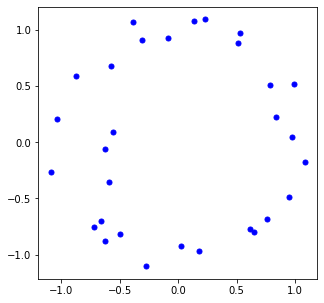

In [6]:
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=25, c="b")
plt.show()

In [7]:
# your code here

## Learning with persistence diagrams

Train the transformer model on the ORBIT2K dataset with 80/20 train/test split. Report the average and standard deviation of the best achieved performance over 3 runs.

**(1 point)** Update `PersistenceDataset` class to output:
- only $n_i$% most persistent points from each of the $i$-th dimension of a diagram,
- a random sample of $n_i$% points from each of the $i$-th dimension of a diagram proportional to each point persistence, i.e. take the point with maximal persistence with probability 1 and the point with zero persitence with probabiltity 0. Experiment with different probability scaling functions, linear is a good start.

Report the average and standard deviation of the best achieved performance over 3 runs for $n_i = 90, 80, 50$, conclude.


**(1 point)** Implement or reuse public code of at least one attention mechanism different from the standard scaled dot-product self-attention. Compare the performance in terms of accuracy and wall time on ORBIT2K to the scaled dot-product self-attention. Report the average and standard deviation of the best achieved performance over 3 runs, conclude.

Some of, not limited to, attention mechanisms to consider:

- linear attention - https://arxiv.org/abs/2006.16236 or https://arxiv.org/abs/2006.04768,
- flash attention - https://arxiv.org/abs/2205.14135,
- L2 attention - https://arxiv.org/abs/2006.04710,
- k-NN attention - https://arxiv.org/abs/2106.00515,
- normalized attention - https://arxiv.org/abs/2005.09561,
- double stochastic attention - https://arxiv.org/abs/2110.11773,
- Wasserstein attention - https://arxiv.org/abs/2201.06035.

#### Data

In [8]:
def generate_orbit(point_0, r, n):
    
    X = np.zeros([n, 2])
    
    xcur, ycur = point_0[0], point_0[1]
    
    for idx in range(n):
        xcur = (xcur + r * ycur * (1. - ycur)) % 1
        ycur = (ycur + r * xcur * (1. - xcur)) % 1
        X[idx, :] = [xcur, ycur]
    
    return X

def generate_orbits(m, n, rs=[2.5, 3.5, 4.0, 4.1, 4.3], random_state=None):
    
    # m orbits, each of n points of dimension 2
    orbits = np.zeros((m * len(rs), n, 2))
    
    # for each r
    for j, r in enumerate(rs):

        # initial points
        points_0 = random_state.uniform(size=(m,2))

        for i, point_0 in enumerate(points_0):
            orbits[j*m + i] = generate_orbit(points_0[i], rs[j], n)
            
    return orbits

In [9]:
random_state = np.random.RandomState(42)
X_orbit5k = generate_orbits(1000, 150, random_state=random_state)

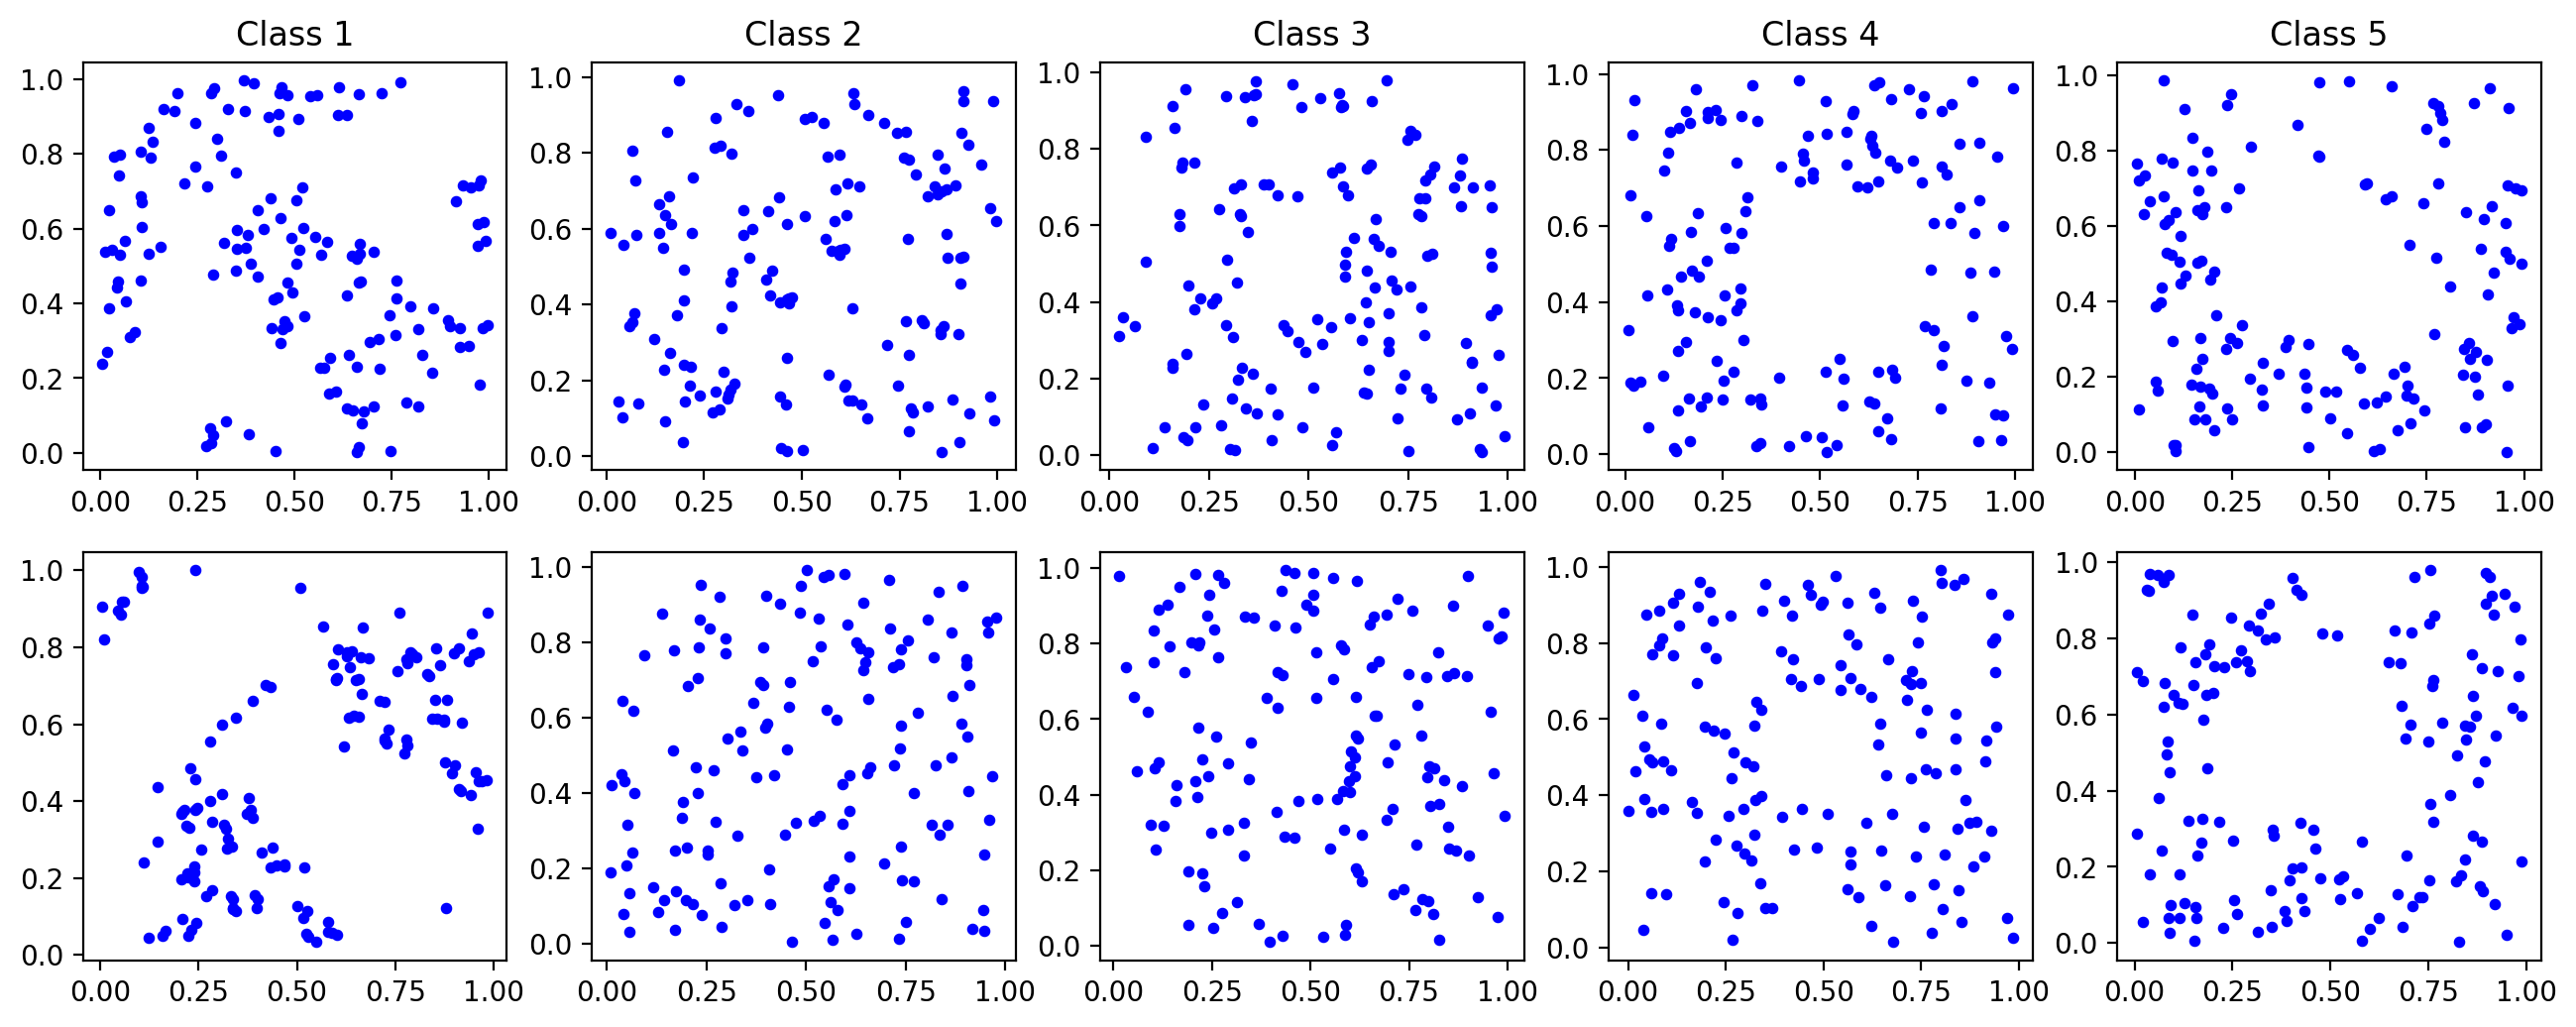

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(16, 6), dpi=200)
for i in range(2):
    for j in range(5):
        if i==0:
            ax[i,j].set_title("Class {}".format(j+1))
        ax[i,j].scatter(X_orbit5k[j*1000+i,:,0], X_orbit5k[j*1000+i,:,1], s=10, c="b")

#### ORBIT2K

Constuct ORBIT2K dataset from 3rd and 5th classes of ORBIT5K

In [11]:
X_pc = np.concatenate((X_orbit5k[2000:3000], X_orbit5k[4000:5000]))
y = np.concatenate((np.zeros(1000), np.ones(1000)))

X = []
vr = Rips()

for x_pc in tqdm(X_pc):
    diagram = torch.tensor(conv_pd(vr.fit_transform(x_pc)))
    X.append(diagram)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 223.31it/s]


#### Torch Dataset and collate_fn

In [12]:
class PersistenceDataset(Dataset):
    
    def __init__(self, diagrams, y):
        super().__init__()
        
        # get diagrams as list of tensors
        D = torch.ones([len(diagrams), max(map(len, diagrams))+1, 3]) * torch.inf  
        for i, dgm in enumerate(diagrams):
            D[i,:len(dgm)] = dgm

        # cut to the largest diagram accross all dataset
        max_len = torch.argmax(D[:,:,0], axis=1).max()
        D = D[:,:max_len+1] # leave at least one inf value!
            
        self.D = D
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.D[idx], self.y[idx]


def collate_fn(batch):

    # get len of a batch and len of each diagram in a batch
    n_batch = len(batch)
    d_lengths = [int(torch.argmax(D[:,0])) for D, y_ in batch]
    
    # set batch tensor to the max length of a diagram in a batch
    Ds = torch.ones([n_batch, max(d_lengths), 3]) * 0.
    D_masks = torch.zeros([n_batch, max(d_lengths)]).bool()
    ys = torch.zeros(n_batch).long()
    
    # populate diagrams, their masks, and targets
    for i, (D, y) in enumerate(batch):
        Ds[i][:d_lengths[i]] = D[:d_lengths[i]]
        D_masks[i][d_lengths[i]:] = True
        ys[i] = y
    
    return Ds, D_masks, ys

#### Model

In [13]:
class PersistentHomologyTransformer(nn.Module):
    
    def __init__(self, d_in=3, d_out=5, d_model=16, d_hidden=32, num_heads=2, num_layers=2, dropout=0.0):
        super().__init__()
        self.linear_in = nn.Linear(d_in, d_model)
        el = nn.TransformerEncoderLayer(d_model, num_heads, d_hidden, dropout, batch_first=True, activation=F.gelu)
        self.encoder = nn.TransformerEncoder(el, num_layers)
        self.linear_out = nn.Linear(d_model, d_out)
        
    def _masked_mean(self, X, mask):
        X_masked = X * ~mask.unsqueeze(-1)
        n_masks = torch.sum(~mask, axis=1)
        X_masked_mean = torch.sum(X_masked, axis=1) / n_masks.unsqueeze(-1)
        return X_masked_mean
        
    def forward(self, X, mask):
        X = self.linear_in(X)
        X = self.encoder(X, src_key_padding_mask=mask)
        X = self._masked_mean(X, mask)
        X = self.linear_out(X)
        return X

#### Train

In [14]:
%%time
n_repeats = 3
n_epochs = 100
batch_size = 16
lr = 0.001

n_train, n_test = 1600, 400

history = np.zeros((n_repeats, n_epochs, 3))
criterion = nn.CrossEntropyLoss()

dataset = PersistenceDataset(X, y)

for repeat_idx in range(n_repeats):
    
    # randomness
    seed = repeat_idx
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # random state
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # data init
    dataset_train, dataset_test = random_split(dataset, [n_train, n_test])
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_test =  DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn)
    
    # model init
    model = PersistentHomologyTransformer(d_in=3, d_out=2)
    optimizer = Adam(model.parameters(), lr=lr)
    
    print("{:3} {:6} {:6} {:6}".format(repeat_idx, "Loss", "Train", "Test"))
    
    for epoch_idx in range(n_epochs):
        
        # train
        model.train()
        
        loss_epoch = []
        for X, mask, y in dataloader_train:
            loss_batch = criterion(model(X, mask), y)
            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_epoch.append(loss_batch.detach())
        
        loss_epoch_mean = np.array(loss_epoch).mean()
        history[repeat_idx,epoch_idx,0] = loss_epoch_mean
        
        # test
        model.eval()
        
        correct = 0
        for X, mask, y in dataloader_train:
            y_hat = model(X, mask).argmax(dim=1)
            correct += int((y_hat == y).sum())
        accuracy_train = correct / len(dataloader_train.dataset)
        history[repeat_idx,epoch_idx,1] = accuracy_train

        correct = 0
        for X, mask, y in dataloader_test:
            y_hat = model(X, mask).argmax(dim=1)
            correct += int((y_hat == y).sum())
        accuracy_test = correct / len(dataloader_test.dataset)
        history[repeat_idx,epoch_idx,2] = accuracy_test
        
        print("{:3} {:.4f} {:.4f} {:.4f}".format(epoch_idx, loss_epoch_mean, accuracy_train, accuracy_test))
    print("\r")

  0 Loss   Train  Test  
  0 0.7037 0.5275 0.5150
  1 0.6761 0.6044 0.5850
  2 0.6651 0.6444 0.6300
  3 0.6554 0.6344 0.6250
  4 0.6420 0.6012 0.6150
  5 0.6403 0.6431 0.6275
  6 0.6448 0.6338 0.6275
  7 0.6449 0.6300 0.6250
  8 0.6494 0.6162 0.6350
  9 0.6359 0.6388 0.6275
 10 0.6380 0.6388 0.6275
 11 0.6403 0.5625 0.5625
 12 0.6324 0.6406 0.6350
 13 0.6312 0.6094 0.5875
 14 0.6356 0.6362 0.6325
 15 0.6374 0.6150 0.5925
 16 0.6277 0.6388 0.6425
 17 0.6306 0.6325 0.6375
 18 0.6305 0.6288 0.6425
 19 0.6291 0.6225 0.6025
 20 0.6223 0.6381 0.6375
 21 0.6269 0.6181 0.5900
 22 0.6197 0.6100 0.6150
 23 0.6307 0.6556 0.6450
 24 0.6198 0.6575 0.6625
 25 0.6116 0.6756 0.6625
 26 0.6027 0.6544 0.6350
 27 0.5919 0.5869 0.5875
 28 0.6026 0.5450 0.5450
 29 0.5995 0.7025 0.6775
 30 0.5904 0.6175 0.6200
 31 0.5743 0.7125 0.7050
 32 0.5624 0.7075 0.7000
 33 0.5496 0.7113 0.7200
 34 0.5324 0.7275 0.7300
 35 0.5216 0.7269 0.7175
 36 0.5235 0.7188 0.7225
 37 0.5194 0.7300 0.7300
 38 0.5177 0.7269 0.7175


In [15]:
x = np.arange(n_epochs)
loss_ci1 = history.mean(axis=0)[:,0] - history.std(axis=0)[:,0]
loss_ci2 = history.mean(axis=0)[:,0] + history.std(axis=0)[:,0]
acc_train_ci1 = history.mean(axis=0)[:,1] - history.std(axis=0)[:,1]
acc_train_ci2 = history.mean(axis=0)[:,1] + history.std(axis=0)[:,1]
acc_test_ci1 = history.mean(axis=0)[:,2] - history.std(axis=0)[:,2]
acc_test_ci2 = history.mean(axis=0)[:,2] + history.std(axis=0)[:,2]

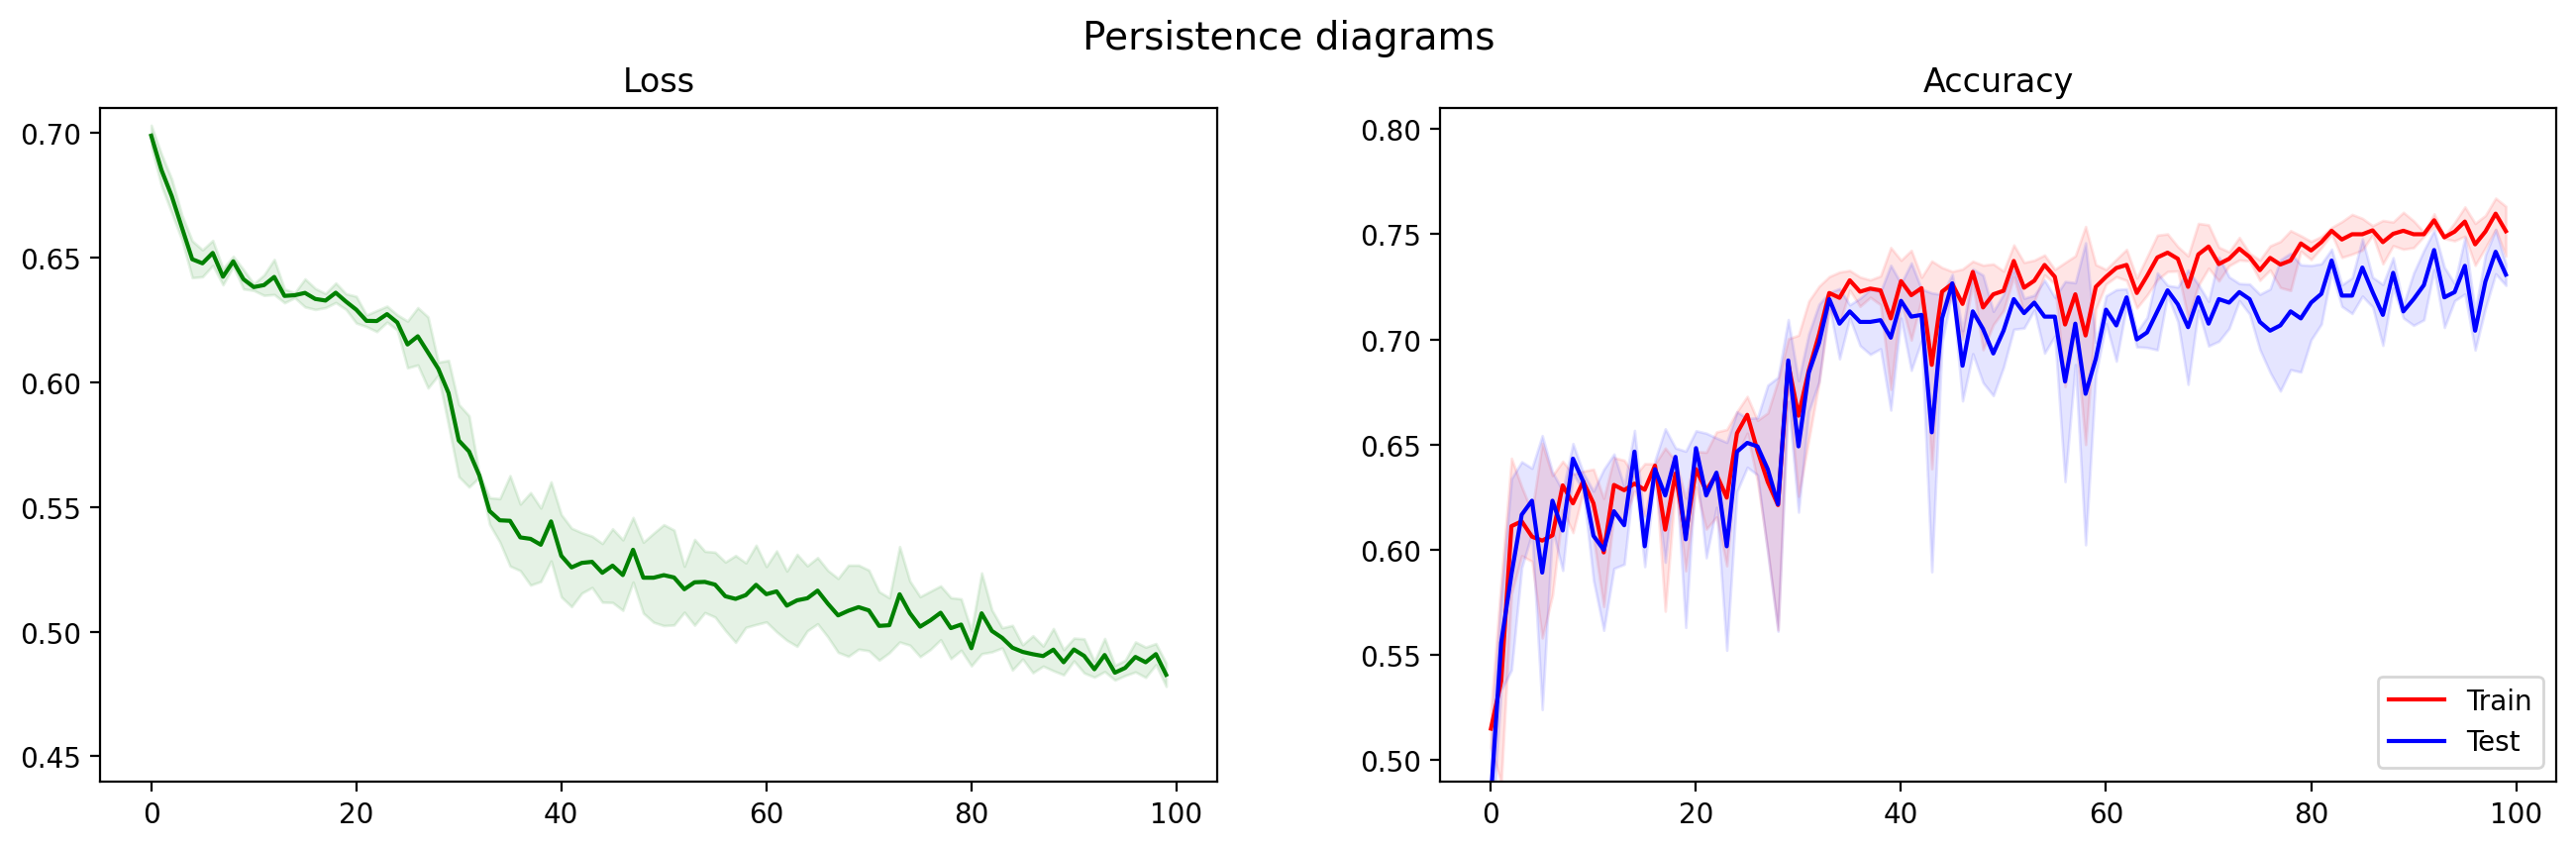

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
fig.suptitle("Persistence diagrams", fontsize=14)
ax[0].set_title("Loss")
ax[1].set_title("Accuracy")
ax[0].set_ylim(0.44, 0.71)
ax[1].set_ylim(0.49, 0.81)
ax[0].plot(history.mean(axis=0)[:,0], c="g")
ax[0].fill_between(x, loss_ci1, loss_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:,1], c="r", label="Train")
ax[1].plot(history.mean(axis=0)[:,2], c="b", label="Test")
ax[1].fill_between(x, acc_train_ci1, acc_train_ci2, color="r", alpha=0.1)
ax[1].fill_between(x, acc_test_ci1, acc_test_ci2, color="b", alpha=0.1)
ax[1].legend(loc=4)
plt.show()

In [17]:
# your code here

## Notes

- each task can be graded with zero, half or full amount of point depending on the completeness of the solution and quality of reporting,
- you can earn up to 2 additional points by reporting a bug in the `SimplicialX` library.